In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split



from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
#!pip install catboost
#from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
directory='/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia'
train_directory=os.path.join(directory,'train')
test_directory=os.path.join(directory,'test')
val_directory=os.path.join(directory,'val')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory( train_directory, 
        classes = ['NORMAL', 'PNEUMONIA'],
        target_size=(224, 224),  
        batch_size=32,
        class_mode='binary')

# Flow validation images in batches of 32 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory( val_directory,
        classes = ['NORMAL', 'PNEUMONIA'],
        target_size=(224, 224), 
        batch_size=32,
        class_mode='binary',
        shuffle=False)

test_generator = test_datagen.flow_from_directory( test_directory,
        classes = ['NORMAL', 'PNEUMONIA'],
        target_size=(224, 224), 
        batch_size=32,
        class_mode='binary',
        shuffle=False)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print("STEP_SIZE_TRAIN: ",STEP_SIZE_TRAIN)
print("STEP_SIZE_TEST: ",STEP_SIZE_TEST)

In [ ]:
model_1 = Sequential()
model_1.add(tf.keras.applications.ResNet101V2(include_top = False, weights="imagenet", input_shape=(224,224,3))) 
model_1.add(tf.keras.layers.GlobalAveragePooling2D())
model_1.add(Dropout(0.4))
model_1.add(Dense(1, activation = 'sigmoid'))
model_1.layers[0].trainable = True

In [ ]:
print("Number of layers in the base model: ", len(model_1.layers[0].layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 188

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_1.layers[0].layers[:fine_tune_at]:
    layer.trainable =  False
model_1.compile(optimizer=tf.keras.optimizers.Adam(0.00001), loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
history = model_1.fit(train_generator,
steps_per_epoch=STEP_SIZE_TRAIN,
epochs=30,
verbose=1,
validation_data = validation_generator,
validation_steps=STEP_SIZE_VAL)

In [ ]:
preds = model_1.predict(test_generator,verbose=1)
final_preds=[]
for i in preds:
    if(i >= 0.5):
        final_preds.append(1)
    else:
        final_preds.append(0)

accuracy = accuracy_score(list(test_generator.classes), final_preds)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(list(test_generator.classes), final_preds)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(list(test_generator.classes), final_preds)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(list(test_generator.classes), final_preds)
print('F1 score: %f' % f1)
fpr, tpr, _ = roc_curve(list(test_generator.classes), final_preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
pr, tpr, _ = roc_curve(list(test_generator.classes), final_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

plt.plot(history.history['accuracy'],marker = 'v')
plt.plot(history.history['val_accuracy'],marker = '*')
plt.title('RAN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],marker = 'v')
plt.plot(history.history['val_loss'],marker = '*')
plt.title('RAN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_1.save_weights('R_Resnet101V2.h5')

In [ ]:
history.history

In [ ]:
# getting class weights for last layer in model
class_weights = model_1.layers[-1].get_weights()[0]

# commening process of getting class weights for last convolutional layer by first defining it
final_conv_layer = model_1.layers[0].layers[-1]

# defining a backend function to get outputs for various layers in the model
get_output = tf.keras.backend.function([model_1.layers[0].layers[0].input], 
                                       [final_conv_layer.output])

In [ ]:
def prepare_image(file):
    from keras.preprocessing import image
    img = image.load_img(file, target_size=(229, 229))
    img_array = image.img_to_array(img)
    img_array=img_array/255
    return img_array

In [ ]:
image_loaded = cv2.imread('/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/test/NORMAL/IM-0206-0001.jpeg')
image_loaded = cv2.cvtColor(image_loaded, cv2.COLOR_BGR2RGB)
image_loaded = cv2.resize(image_loaded, (224,224))
image_loaded = np.asarray(image_loaded)
prep_loaded = tf.keras.applications.xception.preprocess_input(image_loaded)
prep_loaded = np.expand_dims(prep_loaded, axis=0)

In [ ]:
[conv_outputs] = get_output(prep_loaded)
conv_outputs = conv_outputs[0, :, :, :]

In [ ]:
cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
# iterating through weights and adding them to activation map
for index, weight in enumerate(class_weights[:, 0]):
  cam += weight * conv_outputs[:, :, index]

# normalizing activation map
cam = np.maximum(cam, 0)
cam /= np.max(cam)

In [ ]:
# postprocessing heatmap
heatmap = cv2.resize(cam, (299, 299))
heatmap = heatmap * 255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)

# superimposing heatmap and image
img = heatmap * 0.5 + image_loaded
img = np.clip(img, 0, 255).astype(np.uint8)

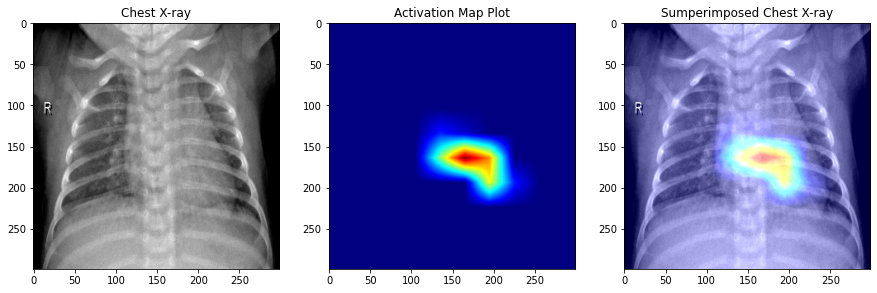

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

# plotting original image
ax[0].imshow(image_loaded)
ax[0].set_title('Chest X-ray', 
                fontsize = 12)

# plotting activation map
ax[1].imshow(heatmap)
ax[1].set_title('Activation Map Plot', 
                fontsize = 12)

# plotting superimposed image
ax[2].imshow(img)
ax[2].set_title('Sumperimposed Chest X-ray', 
                fontsize = 12)
plt.show()

In [ ]:
X_train_normal = np.load('/content/drive/MyDrive/train_normal_299.npy', allow_pickle=True)
X_train_pnemonia = np.load('/content/drive/MyDrive/train_pnemonia_299.npy', allow_pickle=True)
X_test_normal= np.load('/content/drive/MyDrive/test_normal_299.npy', allow_pickle=True)
X_test_pnemonia = np.load('/content/drive/MyDrive/test_pnemonia_299.npy', allow_pickle=True)

In [ ]:
model_1 = Sequential()
model_1.add(tf.keras.applications.Xception(include_top = False, weights="imagenet", input_shape=(299, 299,3)))
model_1.add(tf.keras.layers.GlobalAveragePooling2D())
model_1.add(Dropout(0.4))
model_1.add(Dense(1, activation = 'sigmoid'))
model_1.layers[0].trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 66

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_1.layers[0].layers[:fine_tune_at]:
    layer.trainable =  False
#model_1.compile(optimizer=Nadam(0.001), loss = 'binary_crossentropy', metrics = 'accuracy')
model_1.load_weights('/content/drive/MyDrive/Xception(30).h5')

In [ ]:
model_1.pop()
MobileNet_train_normal_features = model_1.predict(X_train_normal,verbose=1)
MobileNet_train_pnemonia_features = model_1.predict(X_train_pnemonia,verbose=1)
MobileNet_test_normal_features = model_1.predict(X_test_normal,verbose=1)
MobileNet_test_pnemonia_features = model_1.predict(X_test_pnemonia,verbose=1)

In [ ]:
train_nomral_labels=np.zeros((MobileNet_train_normal_features.shape[0]),dtype=int)
train_pneumonia_labels=np.ones((MobileNet_train_pnemonia_features.shape[0]),dtype=int)
test_normal_labels=np.zeros((MobileNet_test_normal_features.shape[0]),dtype=int)
test_pneumonia_labels=np.ones((MobileNet_test_pnemonia_features.shape[0]),dtype=int)

train_features = np.concatenate((MobileNet_train_normal_features, MobileNet_train_pnemonia_features))
train_labels= np.concatenate((train_nomral_labels, train_pneumonia_labels))

test_features=np.concatenate((MobileNet_test_normal_features, MobileNet_test_pnemonia_features))
test_labels=np.concatenate((test_normal_labels, test_pneumonia_labels))

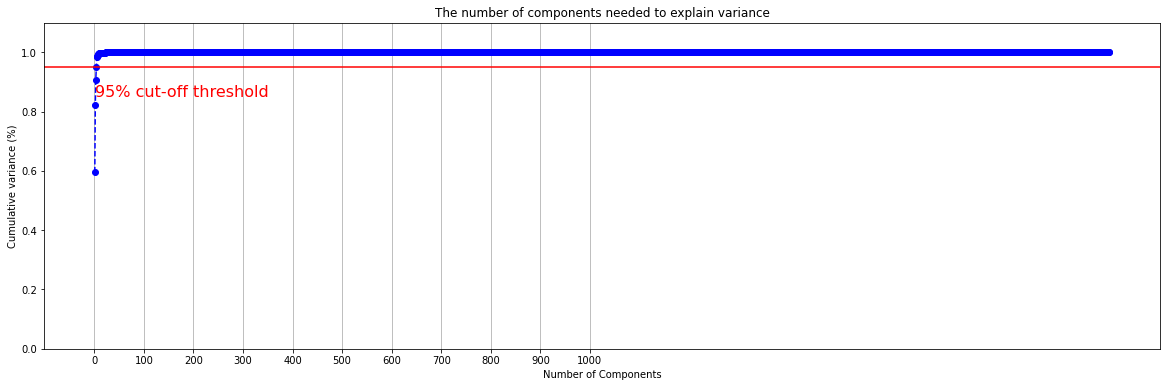

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
pca = PCA().fit(np.concatenate((MobileNet_train_normal_features,MobileNet_train_pnemonia_features,MobileNet_test_normal_features,MobileNet_test_pnemonia_features)))
% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots()
xi = np.arange(1, 2049, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 1025, step=100)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 587 samples in 0.002s...
[t-SNE] Computed neighbors for 587 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 587 / 587
[t-SNE] Mean sigma: 1.981653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.079796
[t-SNE] KL divergence after 300 iterations: 0.398940


[Text(0.5, 1.0, 'Pediatric Pneumonia Test data T-SNE projection')]

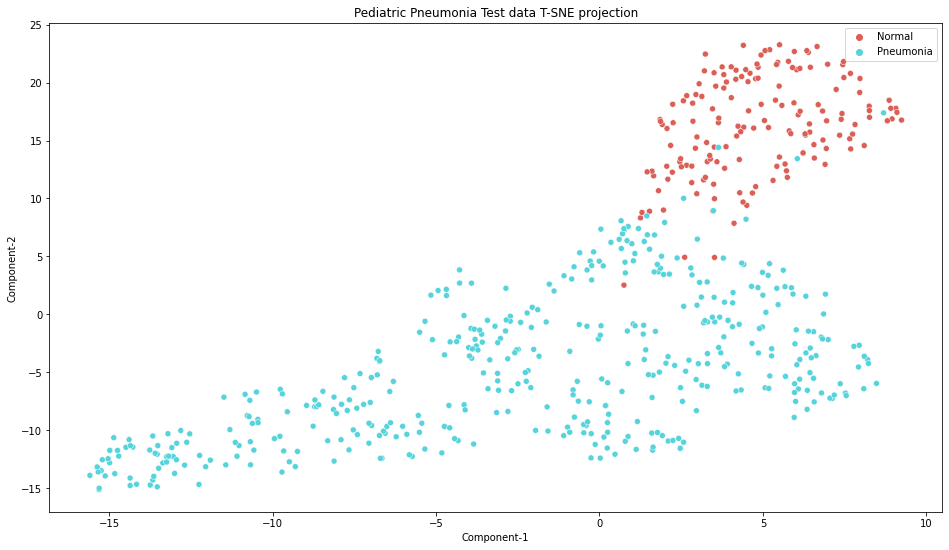

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

test_features=np.concatenate((MobileNet_test_normal_features, MobileNet_test_pnemonia_features))
test_labels=np.concatenate((test_normal_labels, test_pneumonia_labels))

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(test_features)
df = pd.DataFrame()
df["y"] = test_labels
df["Component-1"] = tsne_results[:,0]
df["Component-2"] = tsne_results[:,1]
category_to_label = {0: 'Normal', 1:'Pneumonia'}

plt.figure(figsize=(16,9))
sns.scatterplot(x="Component-1", y="Component-2" ,legend="full",alpha=1, hue= map(lambda x: "Normal" if x == 0 else "Pneumonia", df.y.tolist()),palette=sns.color_palette("hls", 2), data=df).set(title="Pediatric Pneumonia Test data T-SNE projection") 

In [ ]:
pca = KernelPCA(n_components=200 , kernel='rbf')
train_features=pca.fit_transform(train_features) 
test_features=pca.fit_transform(test_features)  

In [ ]:
def metrics(test_labels, preds):
  accuracy = accuracy_score(test_labels, preds)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(test_labels, preds)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(test_labels, preds)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_labels, preds)
  print('F1 score: %f' % f1)

  fpr, tpr, _ = roc_curve(test_labels, preds)
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
  lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()


### With PCA

StackingClassifier
Accuracy: 0.982964
Precision: 0.992925
Recall: 0.983645
F1 score: 0.988263
0.9823884676423912


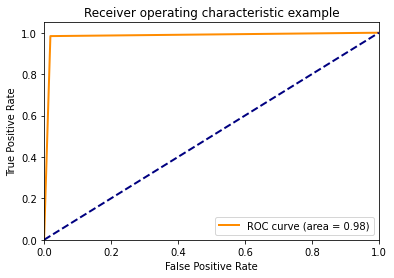

In [ ]:
print("StackingClassifier")
estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=100, criterion='gini', min_samples_split=2 , min_samples_leaf=1, min_weight_fraction_leaf=0.0, min_impurity_decrease=0.0 , ccp_alpha=0.0)),
    ('svr', make_pipeline(StandardScaler(),SVC(C=1.0, kernel='poly', degree=3, gamma='scale', coef0=0.0 , tol=1e-3))),
    ('KNN', make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors  =5, weights='uniform', leaf_size=30,p=2))),
    ('X', make_pipeline(StandardScaler(),XGBClassifier(
        
        loss= 'deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion= 'friedman_mse', min_samples_split=2 , min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3
    ))),

    ('Xa', make_pipeline(StandardScaler(),LogisticRegression(penalty='l2', tol= 1e-4, C=1.0, solver= 'lbfgs',max_iter=100 ))),
    ('Xa2', make_pipeline(StandardScaler(),NuSVC( kernel='rbf', degree=1, gamma='scale', probability=True, nu=0.25 , tol= 1e-3))),
    ('Xa3', make_pipeline(StandardScaler(),MLPClassifier(hidden_layer_sizes = (50,10,10,10), activation ='tanh',solver='adam')))  
    ]

cv= StratifiedKFold(n_splits=10)
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(penalty='l2', tol=1e-4, C=1.0, solver= 'lbfgs', max_iter=100),cv=cv)
clf.fit(train_features,train_labels)
preds=clf.predict(test_features)
metrics(test_labels, preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Without PCA

StackingClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.977853
Precision: 0.990544
Recall: 0.978972
F1 score: 0.984724
0.9769073649562099


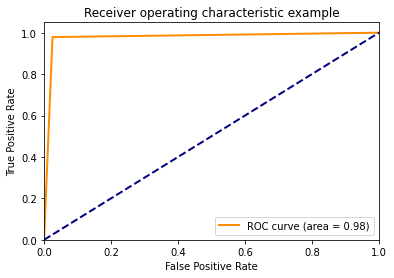

In [ ]:
print("StackingClassifier")
estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=100, criterion='gini', min_samples_split=2 , min_samples_leaf=1, min_weight_fraction_leaf=0.0, min_impurity_decrease=0.0 , ccp_alpha=0.0)),
    ('svr', make_pipeline(StandardScaler(),SVC(C=1.0, kernel='poly', degree=3, gamma='scale', coef0=0.0 , tol=1e-3))),
    ('KNN', make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors  =5, weights='uniform', leaf_size=30,p=2))),
    ('X', make_pipeline(StandardScaler(),XGBClassifier(
        
        loss= 'deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion= 'friedman_mse', min_samples_split=2 , min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3
    ))),

    ('Xa', make_pipeline(StandardScaler(),LogisticRegression(penalty='l2', tol= 1e-4, C=1.0, solver= 'lbfgs',max_iter=100 ))),
    ('Xa2', make_pipeline(StandardScaler(),NuSVC( kernel='rbf', degree=1, gamma='scale', probability=True, nu=0.25 , tol= 1e-3))),
    ('Xa3', make_pipeline(StandardScaler(),MLPClassifier(hidden_layer_sizes = (50,10,10,10), activation ='tanh',solver='adam')))  
    ]

cv= StratifiedKFold(n_splits=10)
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(penalty='l2', tol=1e-4, C=1.0, solver= 'lbfgs', max_iter=100),cv=cv)
clf.fit(np.concatenate((MobileNet_train_normal_features, MobileNet_train_pnemonia_features)),train_labels)
preds=clf.predict(np.concatenate((MobileNet_test_normal_features, MobileNet_test_pnemonia_features)))
metrics(test_labels, preds)

Confusion matrix, without normalization
[[155   4]
 [  9 419]]


<Figure size 10000x10000 with 0 Axes>

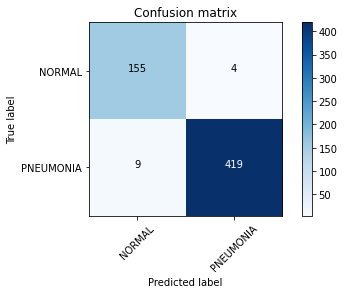

In [ ]:
cnf_matrix = confusion_matrix(test_labels,preds)
from matplotlib.pyplot import figure

np.set_printoptions(precision=2)
figure(figsize=(10, 10), dpi=1000)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NORMAL','PNEUMONIA'],
                      title='Confusion matrix')


plt.show()